In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt

import tensorflow as tf

import yaml
import time
import glob
# from memory_profiler import profile

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

### download data

In [3]:
from transform_inputs import get_data

In [4]:
# %%memit
taus = get_data('data/ShuffleMergeSpectral_1.root', 'taus', step_size='1000 MB')
n_taus = len(taus)

In [5]:
tau_i = 7 # random tau index for illustrative purposes

In [6]:
# taus
# taus.fields

In [7]:
ak.num(taus.pfCand_pt), ak.num(taus.ele_pt), ak.num(taus.muon_pt)

(<Array [28, 31, 58, 28, 37, ... 54, 40, 42, 54] type='191700 * int64'>,
 <Array [0, 0, 0, 2, 0, 0, ... 0, 0, 0, 0, 1, 0] type='191700 * int64'>,
 <Array [1, 3, 3, 0, 1, 0, ... 0, 0, 1, 0, 0, 1] type='191700 * int64'>)

### define the grid

In [10]:
grid_types = ['inner', 'outer']
grid_dim = ['eta', 'phi']
grid_size, grid_left, grid_right = {}, {}, {}

In [11]:
n_cells = {'inner': 11, 'outer': 21}
cell_size = {'inner': 0.02, 'outer': 0.05}

In [12]:
for grid_type in grid_types:
    grid_size[grid_type] = cell_size[grid_type] * n_cells[grid_type]
    grid_left[grid_type], grid_right[grid_type] = - grid_size[grid_type] / 2, grid_size[grid_type] / 2

### derive constituents' features

In [13]:
from transform_inputs import add_vars_to_taus

In [14]:
constituent_types = ['ele', 'muon', 'pfCand']

In [15]:
fill_branches = {'ele': ['ele_pt', 'ele_deta', 'ele_dphi', 'ele_mass',],
                 'muon': ['muon_pt', 'muon_deta', 'muon_dphi', 'muon_mass',],
                 'pfCand': ['pfCand_pt', 'pfCand_deta', 'pfCand_dphi', 'pfCand_mass',]
                 } # branches to be stored

In [16]:
# more features to be put here

In [17]:
# %%timeit
for c_type in constituent_types: 
    add_vars_to_taus(taus, c_type)

In [18]:
taus[tau_i]['n_ele'],  taus[tau_i]['n_muon'], taus[tau_i]['n_pfCand'],

(0, 0, 55)

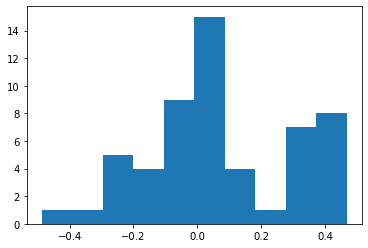

In [19]:
plt.hist(taus[tau_i].pfCand_deta)
plt.show()

### derive inner/outer grid masks

In [20]:
from transform_inputs import derive_grid_mask

In [21]:
# grid masks placeholder
grid_mask_dict = {key: {} for key in grid_types}

In [22]:
# %%timeit
for c_type in constituent_types:
    for grid_type in grid_types:
        grid_mask_dict[grid_type][c_type] = derive_grid_mask(taus, c_type, grid_type)
    taus[f'inner_grid_{c_type}_mask'] = grid_mask_dict['inner'][c_type]
    taus[f'outer_grid_{c_type}_mask'] = grid_mask_dict['outer'][c_type] * (~grid_mask_dict['inner'][c_type])

In [23]:
for c_type in constituent_types:  
    for grid_type in grid_types:
        print(f'{c_type}: total {sum(taus[f"{grid_type}_grid_{c_type}_mask"][tau_i])} constituents in the {grid_type} cone for tau with i={tau_i}')
    print()

ele: total 0 constituents in the inner cone for tau with i=7
ele: total 0 constituents in the outer cone for tau with i=7

muon: total 0 constituents in the inner cone for tau with i=7
muon: total 0 constituents in the outer cone for tau with i=7

pfCand: total 13 constituents in the inner cone for tau with i=7
pfCand: total 42 constituents in the outer cone for tau with i=7



In [24]:
print(15*'*')
for c_type in constituent_types: 
    print()
    for grid_type in grid_types:  
        grid_mask = taus[f"{grid_type}_grid_{c_type}_mask"]
        print(f'{c_type}: total count of constituents per tau in the {grid_type} cone\n{ak.sum(grid_mask, axis=1)}')
        print()
    print(15*'*')

***************

ele: total count of constituents per tau in the inner cone
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

ele: total count of constituents per tau in the outer cone
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

***************

muon: total count of constituents per tau in the inner cone
[1, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ... 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]

muon: total count of constituents per tau in the outer cone
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

***************

pfCand: total count of constituents per tau in the inner cone
[1, 5, 14, 1, 3, 18, 3, 13, 1, 15, 2, 2, ... 5, 2, 7, 4, 13, 9, 9, 11, 10, 6, 3, 6]

pfCand: total count of constituents per tau in the outer cone
[27, 26, 44, 27, 34, 28, 28, 42, 27, 61, ... 24, 35, 40, 45, 36, 31, 44, 34, 39, 48]

***************


### derive cell indices 

In [25]:
from transform_inputs import derive_cell_indices

In [26]:
# %%timeit
for c_type in constituent_types: 
    for grid_type in grid_types:
        for dim in grid_dim:
            taus[f'{grid_type}_grid_{c_type}_indices_{dim}'] = derive_cell_indices(taus, c_type, grid_type, dim)

In [27]:
print(15*'*')
for c_type in constituent_types: 
    for grid_type in grid_types:      
        grid_mask = taus[f"{grid_type}_grid_{c_type}_mask"]
        print()
        print(f'{c_type}: eta indices of constituents for tau with i={tau_i} in the {grid_type} cone\n{taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i]}')
    print(15*'*')

***************

ele: eta indices of constituents for tau with i=7 in the inner cone
[]

ele: eta indices of constituents for tau with i=7 in the outer cone
[]
***************

muon: eta indices of constituents for tau with i=7 in the inner cone
[]

muon: eta indices of constituents for tau with i=7 in the outer cone
[]
***************

pfCand: eta indices of constituents for tau with i=7 in the inner cone
[5, 8, 6, 5, 5, 5, 5, 4, 4, 3, 0, 7, 9]

pfCand: eta indices of constituents for tau with i=7 in the outer cone
[15, 12, 9, 5, 10, 10, 12, 10, 18, 19, 16, ... 16, 13, 12, 11, 10, 10, 7, 6, 5, 3]
***************


### validating indices

In [28]:
grid_type = 'outer'
c_type = 'pfCand'
tau_i = 10

In [29]:
grid_mask = taus[f'{grid_type}_grid_{c_type}_mask']
grid_coord = ak.to_pandas(taus[[f'{c_type}_deta', f'{c_type}_dphi', ]][grid_mask][tau_i])
grid_coord

,pfCand_deta,pfCand_dphi
entry,,
0,0.448764,-0.175213
1,0.486302,-0.060366
2,-0.096724,-0.242806
3,0.156519,0.374124
4,0.202663,-0.382540
5,-0.104415,0.112392
6,-0.258228,0.230261
7,0.000508,-0.485674
8,0.218593,0.333297


In [30]:
eta_indices = taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i].tolist()
phi_indices = taus[f"{grid_type}_grid_{c_type}_indices_phi"][grid_mask][tau_i].tolist()
for i,j in zip(eta_indices, phi_indices):
    print(i,j)

19.0 6.0
20.0 9.0
8.0 5.0
13.0 17.0
14.0 2.0
8.0 12.0
5.0 15.0
10.0 0.0
14.0 17.0
14.0 18.0
11.0 16.0
7.0 13.0


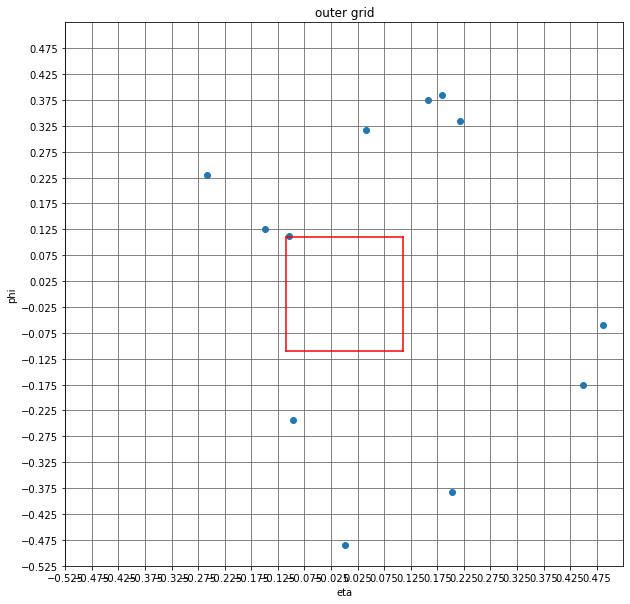

In [31]:
fig, ax = plt.subplots(1, figsize=(10, 10))

if grid_type != 'inner':
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_right['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_left['inner']], [grid_left['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_left['inner'], grid_left['inner']], 'r')
    ax.plot([grid_right['inner'], grid_right['inner']], [grid_left['inner'], grid_right['inner']], 'r')

ax.scatter(x=grid_coord[f'{c_type}_deta'], y=grid_coord[f'{c_type}_dphi'])

ax.set_xlim(grid_left[grid_type], grid_right[grid_type])
ax.set_ylim(grid_left[grid_type], grid_right[grid_type])
ax.set_xticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))
ax.set_yticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))

ax.set_xlabel('eta')
ax.set_ylabel('phi')
ax.set_title(f'{grid_type} grid')

plt.grid(b=True, which='major', color='#666666', linestyle='-') 

plt.show()

### fill final tensor

In [32]:
from transform_inputs import get_grid_mask, get_fill_indices, get_fill_values

In [33]:
# initialize tensors to be filled 
grid_tensors = {key: {} for key in grid_types}
for c_type in constituent_types:
    for grid_type in grid_types:
        grid_tensors[grid_type][c_type] = np.zeros((n_taus, n_cells[grid_type], n_cells[grid_type], len(fill_branches[c_type])))

In [34]:
# limit with this value
n_taus = 1000 

In [35]:
# dictionaries to store timing
get_mask_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
get_fill_indices_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
get_fill_values_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
fill_tensor_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}

program_starts = time.time()
for i_tau, tau in enumerate(taus):
    if i_tau%100 == 0:
        print(f'---> processing {i_tau}th tau')
    if i_tau == n_taus:
        break
    for c_type in constituent_types:
        for grid_type in grid_types:        
            begin_iter = time.time()
            # get mask
            grid_mask = get_grid_mask(tau, c_type, grid_type)
            after_get_mask = time.time()
            get_mask_times[grid_type][c_type].append(after_get_mask - begin_iter)

            # get indices
            indices_eta, indices_phi = get_fill_indices(tau, c_type, grid_type, grid_mask)
            after_get_fill_indices = time.time()
            get_fill_indices_times[grid_type][c_type].append(after_get_fill_indices - after_get_mask)

            # get values
            values_to_fill = get_fill_values(tau, fill_branches[c_type], grid_mask)
            after_get_fill_values = time.time()
            get_fill_values_times[grid_type][c_type].append(after_get_fill_values - after_get_fill_indices)

            # put them in the tensor
            grid_tensors[grid_type][c_type][i_tau, indices_eta, indices_phi, :] = values_to_fill
            after_put = time.time()
            fill_tensor_times[grid_type][c_type].append(after_put - after_get_fill_values)       
program_ends = time.time()

---> processing 0th tau
---> processing 100th tau
---> processing 200th tau
---> processing 300th tau
---> processing 400th tau
---> processing 500th tau
---> processing 600th tau
---> processing 700th tau
---> processing 800th tau
---> processing 900th tau
---> processing 1000th tau


In [36]:
print(f'Processed {n_taus} taus in {program_ends - program_starts} seconds\n')
for c_type in constituent_types:
    print(f'=== {c_type}\n')
    for grid_type in grid_types:
        print(f'------- {grid_type} cell')
        print(f'median get_grid_mask() time: {np.median(get_mask_times[grid_type][c_type])}')
        print(f'median get_fill_indices() time: {np.median(get_fill_indices_times[grid_type][c_type])}')
        print(f'median get_fill_values() time: {np.median(get_fill_values_times[grid_type][c_type])}')
        print(f'median fill tensor time: {np.median(fill_tensor_times[grid_type][c_type])}')
        print()
    print()

Processed 1000 taus in 32.346843242645264 seconds

=== ele

------- inner cell
median get_grid_mask() time: 3.0040740966796875e-05
median get_fill_indices() time: 0.00044655799865722656
median get_fill_values() time: 0.004543423652648926
median fill tensor time: 0.0001895427703857422

------- outer cell
median get_grid_mask() time: 3.695487976074219e-05
median get_fill_indices() time: 0.0004444122314453125
median get_fill_values() time: 0.004543900489807129
median fill tensor time: 0.00018787384033203125


=== muon

------- inner cell
median get_grid_mask() time: 3.695487976074219e-05
median get_fill_indices() time: 0.0004420280456542969
median get_fill_values() time: 0.0045299530029296875
median fill tensor time: 0.0001900196075439453

------- outer cell
median get_grid_mask() time: 3.719329833984375e-05
median get_fill_indices() time: 0.00044155120849609375
median get_fill_values() time: 0.004541158676147461
median fill tensor time: 0.00018835067749023438


=== pfCand

------- inner 

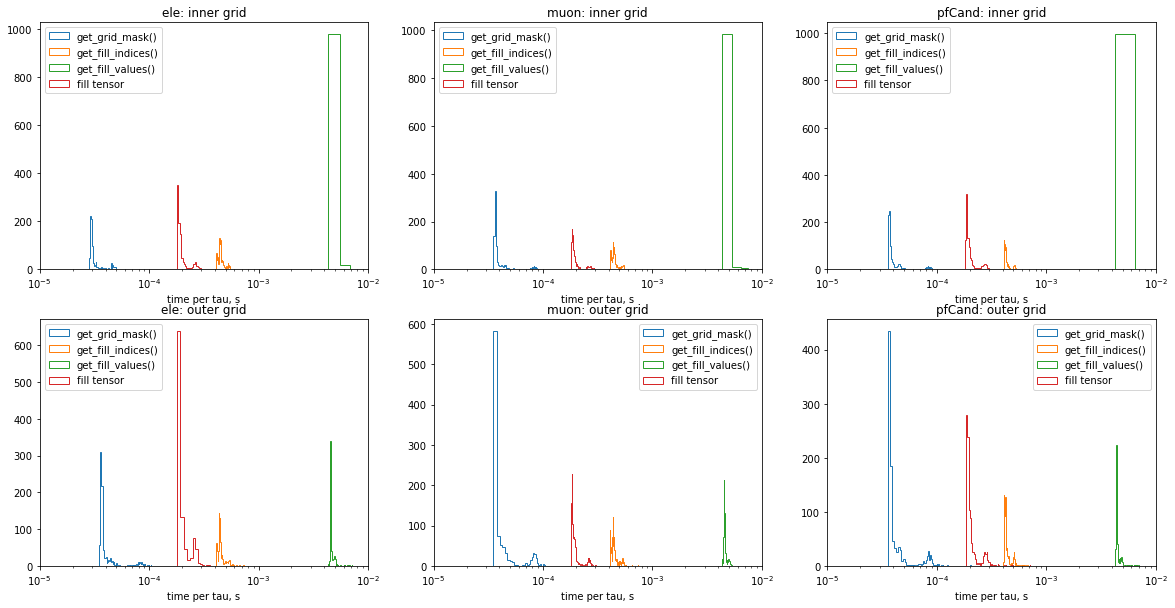

In [37]:
f, ax = plt.subplots(len(grid_types), len(constituent_types), figsize=(20,10))
for i, grid_type in enumerate(grid_types):
    for j, c_type in enumerate(constituent_types):
        ax[i,j].hist(get_mask_times[grid_type][c_type], histtype='step', bins=100, label='get_grid_mask()')
        ax[i,j].hist(get_fill_indices_times[grid_type][c_type], histtype='step', bins=100, label='get_fill_indices()')
        ax[i,j].hist(get_fill_values_times[grid_type][c_type], histtype='step', bins=100, label='get_fill_values()')
        ax[i,j].hist(fill_tensor_times[grid_type][c_type], histtype='step', bins=100, label='fill tensor')
        ax[i,j].set_xlabel('time per tau, s')
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim((1e-5, 1e-2))
        ax[i,j].set_title(f'{c_type}: {grid_type} grid')
        ax[i,j].legend()

### validating final tensor

In [38]:
grid_type = 'inner'
c_type = 'pfCand'
tau_i = 10

In [39]:
grid_mask = taus[f'{grid_type}_grid_{c_type}_mask']
grid_coord = ak.to_pandas(taus[[f'{c_type}_deta', f'{c_type}_dphi', ]][grid_mask][tau_i])
grid_coord

,pfCand_deta,pfCand_dphi
entry,,
0,-0.063398,0.010041
1,0.076316,-0.012617


In [40]:
feature_i = 2

In [41]:
eta_indices = taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i].tolist()
phi_indices = taus[f"{grid_type}_grid_{c_type}_indices_phi"][grid_mask][tau_i].tolist()
vals = taus[fill_branches[c_type][feature_i]][grid_mask][tau_i]
for x,y,v in sorted(zip(eta_indices, phi_indices, vals)):
    print(x,y,v)

2.0 6.0 0.010040640830993652
9.0 4.0 -0.012616664171218872


In [43]:
nonzero_idx_eta = np.argwhere(grid_tensors[grid_type][c_type][tau_i, :, :, feature_i])[:, 0]
nonzero_idx_phi = np.argwhere(grid_tensors[grid_type][c_type][tau_i, :, :, feature_i])[:, 1]
nonzero_vals = grid_tensors[grid_type][c_type][tau_i, nonzero_idx_eta, nonzero_idx_phi, feature_i]
for x,y,v in sorted(zip(nonzero_idx_eta, nonzero_idx_phi, nonzero_vals)):
    print(x,y,v)

2 6 0.010040640830993652
9 4 -0.012616664171218872


## Backup

**Note:** currently, filling with indices works incorrectly. Input to np.put() should be different.

* Ways out: try simple indexing for filling -> make 3 arrays [eta_idx], [phi_idx], [f_idx] and then  
tensor[tau_idx, eta_idx, phi_idx, f_idx] = values  
more in advanced indexing: https://numpy.org/doc/stable/reference/arrays.indexing.html

* or make SparseTensor() and then convert it into dense one


In [25]:
fill_branches = {'pfCand': ['pfCand_pt', 'pfCand_deta', 'pfCand_dphi', 'pfCand_mass',]}
c_type = 'pfCand'

In [26]:
grid_tensors = {}
for grid_type in grid_types:
    grid_tensors[grid_type] = np.zeros((n_taus, n_cells[grid_type], n_cells[grid_type], len(fill_branches[c_type])))

In [116]:
# @nb.jit()
def get_fill_indices(grid_type, i_tau, c_type): 
    grid_mask = taus[i_tau][f'{grid_type}_grid_{c_type}_mask']
    i_eta, i_phi, i_feature = ak.broadcast_arrays(taus[i_tau][f'{grid_type}_grid_{c_type}_indices_eta'][grid_mask],
                                                      taus[i_tau][f'{grid_type}_grid_{c_type}_indices_phi'][grid_mask],
                                                      np.arange(len(fill_branches[c_type]), dtype=np.float32)[:, np.newaxis])
    i_eta_phi_feature = ak.zip([i_eta, i_phi, i_feature])
    indices_to_fill = ak.flatten(i_eta_phi_feature, axis=1)
    indices_to_fill = ak.values_astype(indices_to_fill, 'int32')
    return ak.to_list(indices_to_fill)

In [88]:
# @nb.jit()
def get_fill_values(grid_type, i_tau, c_type): 
    grid_mask = taus[i_tau][f'{grid_type}_grid_{c_type}_mask']
    values_to_fill = ak.to_pandas(taus[i_tau][fill_branches[c_type]][grid_mask]).values
    values_to_fill = values_to_fill.transpose().flatten()
    return values_to_fill

In [90]:
get_fill_indices_times = {'inner': [], 'outer': []}
get_fill_values_times = {'inner': [], 'outer': []}
put_times = {'inner': [], 'outer': []}

program_starts = time.time()
for i_tau, tau in enumerate(taus):
    for grid_type in grid_types:        
        begin_iter = time.time()
        # get indices
        indices_to_fill = get_fill_indices(grid_type, i_tau, c_type)
        after_get_fill_indices = time.time()
        get_fill_indices_times[grid_type].append(after_get_fill_indices - begin_iter)
        
        # get values
        values_to_fill = get_fill_values(grid_type, i_tau, c_type)
        after_get_fill_values = time.time()
        get_fill_values_times[grid_type].append(after_get_fill_values - after_get_fill_indices)
        
        # put them in the tensor
        np.put(grid_tensors[grid_type][i_tau], indices_to_fill, values_to_fill)
        after_put = time.time()
        put_times[grid_type].append(after_put - after_get_fill_values)       
program_ends = time.time()

In [91]:
print(f'Processed {n_taus} taus in {program_ends - program_starts} seconds\n')
for grid_type in grid_types:
    print(f'--- {grid_type} cell')
    print(f'median get_fill_indices() time: {np.median(get_fill_indices_times[grid_type])}')
    print(f'median get_fill_values() time: {np.median(get_fill_values_times[grid_type])}')
    print(f'median np.put() time: {np.median(put_times[grid_type])}')
    print()

Processed 3075 taus in 72.73913288116455 seconds

--- inner cell
median get_fill_indices() time: 0.0031423568725585938
median get_fill_values() time: 0.004656553268432617
median np.put() time: 3.4809112548828125e-05

--- outer cell
median get_fill_indices() time: 0.0102081298828125
median get_fill_values() time: 0.005046844482421875
median np.put() time: 0.0002808570861816406



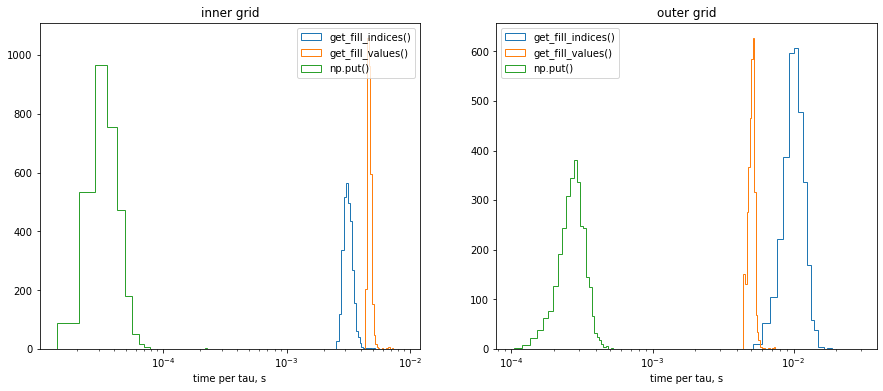

In [152]:
f, ax = plt.subplots(1, 2, figsize=(15,6))
for i, grid_type in enumerate(grid_types):
    ax[i].hist(get_fill_indices_times[grid_type], histtype='step', bins=30, label='get_fill_indices()')
    ax[i].hist(get_fill_values_times[grid_type], histtype='step', bins=30, label='get_fill_values()')
    ax[i].hist(put_times[grid_type], histtype='step', bins=30, label='np.put()')
    ax[i].set_xlabel('time per tau, s')
    ax[i].set_xscale('log')
    ax[i].set_title(f'{grid_type} grid')
    ax[i].legend()
#     ax[i].show()

### misc.

In [117]:
get_fill_indices('inner', 7, 'pfCand')

[(0, 7, 0),
 (5, 5, 0),
 (8, 1, 0),
 (0, 7, 1),
 (5, 5, 1),
 (8, 1, 1),
 (0, 7, 2),
 (5, 5, 2),
 (8, 1, 2),
 (0, 7, 3),
 (5, 5, 3),
 (8, 1, 3)]

In [118]:
get_fill_values('inner', 7, 'pfCand')

array([ 9.06738281e-01,  3.15781250e+01,  3.33593750e+00, -1.07780635e-01,
        7.17937946e-05,  5.26246578e-02,  3.37264538e-02,  4.25577164e-05,
       -7.33020902e-02,  1.39526367e-01,  1.05712891e-01, -0.00000000e+00],
      dtype=float32)

In [119]:
grid_mask = taus[7][f'inner_grid_pfCand_mask']
ak.to_pandas(taus[7][fill_branches['pfCand']][grid_mask])

,pfCand_pt,pfCand_deta,pfCand_dphi,pfCand_mass
entry,,,,
0,0.906738,-0.107781,0.033726,0.139526
1,31.578125,0.000072,0.000043,0.105713
2,3.335938,0.052625,-0.073302,-0.000000


In [121]:
np.put(grid_tensors['inner'][7], get_fill_indices('inner', 7, 'pfCand'), get_fill_values('inner', 7, 'pfCand'))

In [122]:
grid_tensors['inner'][7, 0, 0, 0], grid_tensors['inner'][7, 0, 0, 1], grid_tensors['inner'][7, 0, 0, 2]

(-0.10778063535690308, 0.105712890625, 3.3359375)

In [127]:
a = np.zeros((12, 12, 1))

In [135]:
ind = [[0, 7, 0],
 [5, 5, 0],
 [8, 1, 0],
]

In [136]:
np.put(a, ind, [1,2,3])

In [137]:
a[:, :, 0]

array([[3., 2., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [138]:
np.sum(a != 0)

5

In [142]:
tf.sparse.to_dense(tf.SparseTensor(get_fill_indices('inner', 7, 'pfCand'), get_fill_values('inner', 7, 'pfCand'), (12, 12, 4)))

InvalidArgumentError: indices[3] = [0,7,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]

## [misc]

### single fill

In [32]:
eta_i, phi_i, feature_i = ak.broadcast_arrays(taus[tau_i]['inner_grid_pfCand_indices_eta'][inner_grid_mask[tau_i]],
                            taus[tau_i]['inner_grid_pfCand_indices_phi'][inner_grid_mask[tau_i]],
                            np.arange(len(pf_branches), dtype=np.float32)[:, np.newaxis])
eta_i

<Array [[0, 5, 8], [0, 5, ... 5, 8], [0, 5, 8]] type='4 * 3 * float32'>

In [35]:
eta_phi_feature_i = ak.zip([eta_i, phi_i, feature_i])

<Array [[(0, 7, 0), (5, 5, ... ), (8, 1, 3)]] type='4 * 3 * (float32, float32, f...'>

In [36]:
eta_phi_feature_i[0], eta_phi_feature_i[1], eta_phi_feature_i[2],

(<Array [(0, 7, 0), (5, 5, 0), (8, 1, 0)] type='3 * (float32, float32, float32)'>,
 <Array [(0, 7, 1), (5, 5, 1), (8, 1, 1)] type='3 * (float32, float32, float32)'>,
 <Array [(0, 7, 2), (5, 5, 2), (8, 1, 2)] type='3 * (float32, float32, float32)'>)

In [38]:
indices_to_fill = ak.flatten(eta_phi_feature_i, axis=1)
indices_to_fill = ak.values_astype(indices_to_fill, 'int32')
indices_to_fill = ak.to_list(indices_to_fill)
# indices_to_fill = ak.to_numpy(indices_to_fill)

In [117]:
values_to_fill = ak.to_pandas(taus[tau_i][pf_branches]).values
values_to_fill = values_to_fill.transpose().flatten()
values_to_fill.shape

(232,)

In [26]:
pf_branches = ['pfCand_pt', 'pfCand_deta', 'pfCand_dphi', ]

In [28]:
tau_df = ak.to_pandas(taus[pf_branches + ['inner_grid_pfCand_indices', 'inner_grid_pfCand_mask']])
n_taus = len(tau_df.index.levels[0])
n_taus

3075

In [29]:
tau_df

pfCand_pt pfCand_deta pfCand_dphi inner_grid_pfCand_indices  \
                                                                         0   
entry subentry                                                               
0     0         0.645508   -0.083589    0.347632                       1.0   
      1         0.815918   -0.220189   -0.278948                      -6.0   
      2         0.566406   -0.029388   -0.143703                       4.0   
      3         0.729004   -0.256812   -0.088234                      -8.0   
      4         0.873047    0.156836    0.265015                      13.0   
...                  ...         ...         ...                       ...   
3074  40        4.882812   -0.120702    0.079892                      -1.0   
      41        0.625488   -0.201454    0.234198                      -5.0   
      42        0.691406   -0.288065   -0.149407                      -9.0   
      43        0.451904   -0.322857    0.234294                     -11.0   
      44        0.569824   -0.357465    0.337900                     -13.0   

                     inner_grid_pfCand_mask  
                   1                         
entry subentry                               
0     0         22.0                  False  
      1         -9.0                  False  
      2         -2.0                  False  
      3          1.0                  False  
      4         18.0                  False  
...              ...                    ...  
3074  40         9.0                  False  
      41        17.0                  False  
      42        -2.0                  False  
      43        17.0                  False  
      44        22.0                  False  

[212954 rows x 6 columns]

In [31]:
inner_cand_ids = tau_df.index[tau_df['inner_grid_pfCand_mask']]
inner_grid_ids = tau_df.loc[inner_cand_ids]['inner_grid_pfCand_indices']
inner_grid_ids

0    1
entry subentry          
0     23        5.0  5.0
      43        9.0  4.0
      45        4.0  2.0
1     2         3.0  0.0
      20        5.0  5.0
...             ...  ...
3074  0         3.0  0.0
      11        5.0  5.0
      13        8.0  0.0
      14        0.0  9.0
      31        9.0  2.0

[15853 rows x 2 columns]

In [32]:
inner_grid_fill = tau_df.loc[inner_cand_ids][pf_branches]
inner_grid_fill

pfCand_pt pfCand_deta pfCand_dphi
                                                 
entry subentry                                   
0     23        34.437500   -0.000090   -0.000041
      43         0.618164    0.083958   -0.015660
      45         1.300781   -0.012175   -0.058351
1     2          0.854980   -0.043634   -0.090969
      20        30.109375   -0.000054    0.000041
...                   ...         ...         ...
3074  0          0.759766   -0.046176   -0.102252
      11        20.625000   -0.000032    0.000005
      13         1.535156    0.061310   -0.092192
      14         1.869141   -0.095616    0.071008
      31         0.316406    0.080171   -0.063965

[15853 rows x 3 columns]

In [33]:
inner_grid_fill.loc[0].values

array([[ 3.4437500e+01, -8.9943409e-05, -4.0769577e-05],
       [ 6.1816406e-01,  8.3958030e-02, -1.5660405e-02],
       [ 1.3007812e+00, -1.2175262e-02, -5.8351040e-02]], dtype=float32)

In [34]:
inner_grid_ids.loc[0].values

array([[5., 5.],
       [9., 4.],
       [4., 2.]], dtype=float32)

In [35]:
inner_grid_tensor = np.zeros((n_taus, n_inner_cells, n_inner_cells, len(pf_branches)))

In [64]:
# fill it with values=inner_grid_fill at positions=inner_grid_ids

### misc.

In [37]:
np.meshgrid(inner_grid_eta_ids[0], inner_grid_phi_ids[0])

TypeError: no implementation found for 'numpy.meshgrid' on types that implement __array_function__: [<class 'awkward.highlevel.Array'>]

In [26]:
inner_grid_eta_ids[0][np.newaxis, :]

<Array [... 0, 0, 10, 6, 2, 0, 0, 0, 0, 0]] type='1 * 56 * float64'>

In [31]:
ak.broadcast_arrays(inner_grid_eta_ids[0], inner_grid_eta_ids[0][np.newaxis, :])

[<Array [... 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 0]] type='1 * 56 * float64'>,
 <Array [... 0, 0, 10, 6, 2, 0, 0, 0, 0, 0]] type='1 * 56 * float64'>]

In [57]:
np.outer(ak.to_numpy(inner_grid_eta_ids[0]), ak.to_numpy(inner_grid_phi_ids[0]))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### study default approach

In [3]:
f = uproot.open('data/electron_absetabin1_ptbin11_batch0_out.root')
f.keys()

['taus;1', 'inner_cells;1', 'outer_cells;1']

In [4]:
t = f['taus']
t_inner_cells = f['inner_cells']
t_outer_cells = f['outer_cells']

In [5]:
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | uint32_t                 | AsDtype('>u4')
lumi                 | uint32_t                 | AsDtype('>u4')
evt                  | uint64_t                 | AsDtype('>u8')
npv                  | float                    | AsDtype('>f4')
rho                  | float                    | AsDtype('>f4')
genEventWeight       | float                    | AsDtype('>f4')
trainingWeight       | float                    | AsDtype('>f4')
npu                  | float                    | AsDtype('>f4')
pv_x                 | float                    | AsDtype('>f4')
pv_y                 | float                    | AsDtype('>f4')
pv_z                 | float                    | AsDtype('>f4')
pv_chi2              | float                    | AsDtype('>f4')
pv_ndof              | float                    | AsDtype(

In [6]:
t_inner_cells.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
eta_index            | int32_t                  | AsDtype('>i4')
phi_index            | int32_t                  | AsDtype('>i4')
tau_pt               | float                    | AsDtype('>f4')
rho                  | float                    | AsDtype('>f4')
pfCand_ele_n_total   | int32_t                  | AsDtype('>i4')
pfCand_ele_valid     | float                    | AsDtype('>f4')
pfCand_ele_rel_pt    | float                    | AsDtype('>f4')
pfCand_ele_deta      | float                    | AsDtype('>f4')
pfCand_ele_dphi      | float                    | AsDtype('>f4')
pfCand_ele_tauSignal | float                    | AsDtype('>f4')
pfCand_ele_tauIso    | float                    | AsDtype('>f4')
pfCand_ele_pvAsso... | float                    | AsDtype('>f4')
pfCand_ele_puppiW... | float                    | AsDtype(

In [12]:
inner_cells = t_inner_cells.arrays(library='pd')
inner_cells

,eta_index,phi_index,tau_pt,rho,pfCand_ele_n_total,pfCand_ele_valid,pfCand_ele_rel_pt,pfCand_ele_deta,pfCand_ele_dphi,pfCand_ele_tauSignal,...,muon_n_hits_DT_3,muon_n_hits_DT_4,muon_n_hits_CSC_1,muon_n_hits_CSC_2,muon_n_hits_CSC_3,muon_n_hits_CSC_4,muon_n_hits_RPC_1,muon_n_hits_RPC_2,muon_n_hits_RPC_3,muon_n_hits_RPC_4
0,0,0,0.078513,5.0,1,1.0,0.038542,-0.000268,-0.000484,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2,0,0.078513,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.072178,5.0,1,1.0,0.038952,-0.000005,0.000240,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,-2,0.072178,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0.073862,5.0,1,1.0,0.038443,0.000852,0.000037,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662,-2,1,0.071541,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1663,0,0,0.081446,5.0,1,1.0,0.038547,0.000567,0.000095,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1664,-1,0,0.081446,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665,0,-1,0.081446,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
taus = t.arrays(library='pd')
taus

,run,lumi,evt,npv,rho,genEventWeight,trainingWeight,npu,pv_x,pv_y,...,tau_gj_angle_diff_valid,tau_gj_angle_diff,tau_n_photons,tau_emFraction,tau_inside_ecal_crack,leadChargedCand_etaAtEcalEntrance_minus_tau_eta,innerCells_begin,innerCells_end,outerCells_begin,outerCells_end
0,1,1165,181659,4.770097,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.496562,1.000000,0.0,0.594813,0,2,0,54
1,1,1221,190427,5.000000,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.241915,1.000000,0.0,-1.252759,2,4,54,124
2,1,1249,194829,4.469572,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.496562,1.000000,0.0,0.448020,4,5,124,188
3,1,1262,196782,5.000000,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,0.267380,1.000000,0.0,-0.951892,5,8,188,259
4,1,1299,202498,5.000000,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,0.522027,1.000000,0.0,0.164003,8,11,259,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1,5204,915814,4.018783,4.233082,86.268402,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.241915,0.984084,0.0,-1.014295,1654,1657,62959,63026
1021,1,5204,915837,5.000000,4.916489,86.268402,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.751210,1.000000,0.0,-0.744132,1657,1659,63026,63094
1022,1,5209,916722,3.943651,5.000000,86.268402,0.0,140.0,5.0,-5.0,...,0.0,0.0,0.012732,0.981167,0.0,-0.210171,1659,1660,63094,63148
1023,1,5211,917012,5.000000,5.000000,86.268402,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.751210,1.000000,0.0,-0.509617,1660,1663,63148,63228


In [45]:
taus.innerCells_end

<Array [2, 4, 5, 8, ... 1659, 1660, 1663, 1667] type='1025 * int64'>

In [56]:
df_taus = t.arrays(library='pd', entry_start=1, entry_stop=15)

In [57]:
cells_begin = df_taus['innerCells_begin'].values[0]
cells_end = df_taus['innerCells_end'].values[-1]

In [58]:
df_taus['innerCells_begin']

1      2
2      4
3      5
4      8
5     11
6     13
7     15
8     18
9     19
10    22
11    23
12    24
13    25
14    26
Name: innerCells_begin, dtype: int64

In [59]:
df_taus['innerCells_end']

1      4
2      5
3      8
4     11
5     13
6     15
7     18
8     19
9     22
10    23
11    24
12    25
13    26
14    27
Name: innerCells_end, dtype: int64

In [ ]:
fill_grid_times = []
broadcasting_times = []